<a href="https://colab.research.google.com/github/alinaalborova/russian_idioms_processing/blob/main/MICE_ruBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Idiom Type and Token Classification

Based on [MICE: Mining Idioms with Contextual Embeddings](https://arxiv.org/pdf/2008.05759.pdf) by  Škvorc et al.


In [ ]:
!pip install transformers
!pip install tensor2tensor

     |████████████████████████████████| 2.3MB 25.8MB/s 
     |████████████████████████████████| 3.3MB 32.9MB/s 
     |████████████████████████████████| 901kB 31.3MB/s 
     |████████████████████████████████| 1.5MB 28.9MB/s 
     |████████████████████████████████| 81kB 8.5MB/s 
     |████████████████████████████████| 194kB 40.9MB/s 
     |████████████████████████████████| 983kB 27.6MB/s 
     |████████████████████████████████| 368kB 39.9MB/s 
     |████████████████████████████████| 368kB 39.2MB/s 
     |████████████████████████████████| 655kB 39.1MB/s 
     |████████████████████████████████| 358kB 37.9MB/s 
     |████████████████████████████████| 5.6MB 32.5MB/s 
     |████████████████████████████████| 686kB 28.9MB/s 
     |████████████████████████████████| 256kB 43.0MB/s 
  Created wheel for bz2file: filename=bz2file-0.98-cp37-none-any.whl size=6884 sha256=3bd5a0836296a754932a0961b6e0f1e74fcedcaa1282b628c565e83b7298f526
  Stored in directory: /root/.cache/pip/wheels/81/75/d6/e1317bf09bf

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import tensorflow as tf
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Activation, TimeDistributed, Masking, GRU
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from ast import literal_eval
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from tqdm import tqdm_notebook
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import random

## Dataset

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
dataset_vnc_dir = '/content/drive/MyDrive/ВКР/Sense Disambiguation Corpus/VNCs_Annotated.csv'
data_vnc = pd.read_csv(dataset_vnc_dir )
data_vnc.head(2)

,Idiom Normal,Idiom Inflected,Label,Example
0,бить карту,бил карту,0,Он бил карту за картой и загребал золото и кре...
1,бить карту,бил карту,0,"Ермолов держал карты, сощуря правый глаз; ког..."


In [ ]:
data_vnc.Label.value_counts()

1    455
0    438
Name: Label, dtype: int64

In [ ]:
dataset_anc_dir = '/content/drive/MyDrive/ВКР/Sense Disambiguation Corpus/ANCs_Annotated.csv'
data_anc = pd.read_csv(dataset_anc_dir )
data_anc.head(2)

,Idiom Normal,Idiom Inflected,Label,Example
0,избитая дорога,избитой дороге,0,"С бурной быстротой, возможной только в сновид..."
1,избитая дорога,избитой дороге,0,"Как почтовый возок на избитой дороге, прыгает..."


In [ ]:
data_anc['Idiom Normal'].value_counts()

больное место                 57
правая рука                   56
болевая точка                 52
нож острый                    49
путеводная звезда             48
лавровый венок                44
бедный родственник            41
зелёная улица                 38
тяжёлая рука                  38
ваш брат                      34
вавилонское столпотворение    30
наша сестра                   28
пороховая бочка               27
дальний прицел                25
заблудшая овца                23
вторая ступень                23
старый воробей                22
красная бумажка               21
синяя птица                   20
долгая песня                  18
другой разговор               18
старый гриб                   16
чёрная кость                  15
девичья кожа                  12
музейная редкость             10
маковое зерно                 10
избитая дорога                10
куриная голова                 9
ободранная кошка               9
чернильная строка              3
Name: Idio

In [ ]:
len(data_anc['Idiom Normal'].value_counts())

30

In [ ]:
data_anc['ID'] = pd.Series(np.arange(0, len(data_anc)))
data_anc.head(2)

,Idiom Normal,Idiom Inflected,Label,Example,ID
0,избитая дорога,избитой дороге,0,"С бурной быстротой, возможной только в сновид...",0
1,избитая дорога,избитой дороге,0,"Как почтовый возок на избитой дороге, прыгает...",1


In [ ]:
data_vnc['ID'] = pd.Series(np.arange(len(data_anc), len(data_anc)+len(data_vnc)))
data_vnc.head(2)

,Idiom Normal,Idiom Inflected,Label,Example,ID
0,бить карту,бил карту,0,Он бил карту за картой и загребал золото и кре...,806
1,бить карту,бил карту,0,"Ермолов держал карты, сощуря правый глаз; ког...",807


In [ ]:
data = pd.concat([data_vnc, data_anc], ignore_index=True)
data.head(2)

,Idiom Normal,Idiom Inflected,Label,Example,ID
0,бить карту,бил карту,0,Он бил карту за картой и загребал золото и кре...,806
1,бить карту,бил карту,0,"Ермолов держал карты, сощуря правый глаз; ког...",807


In [ ]:
data.tail(2)

,Idiom Normal,Idiom Inflected,Label,Example,ID
1697,бедный родственник,бедными родственниками,0,"Проходя мимо церквей, я вижу иногда человека,...",804
1698,бедный родственник,бедных родственниках,0,"[Егор Дмитрич Глумов, муж] У молодой женщин...",805


In [ ]:
len(data_anc)

806

In [ ]:
data.shape

(1699, 4)

## Load BERT

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel, TFAutoModel
  
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

BERT_model = AutoModel.from_pretrained('DeepPavlov/rubert-base-cased')

In [ ]:
def get_bert_embeddings_single_sentence(sentence):
  inputs = tokenizer(sentence, return_tensors="pt")
  outputs=BERT_model(**inputs)
  return outputs.last_hidden_state
  
def get_bert_embeddings(sentences, padded_size=150, vec_size=768):
  embeddings_all = []
  #for sentence in tqdm_notebook(sentences):
  for sentence in tqdm_notebook(sentences):
    lhs = get_bert_embeddings_single_sentence(sentence)
    vecs = lhs[0]
    sentence_padded = np.empty(shape=(padded_size, ), dtype=object)
    for id, token in enumerate(sentence_padded):
      try:
        sentence_padded[id] = vecs[id].detach().numpy()
      except:
        sentence_padded[id] = np.zeros(vec_size)
    embeddings_all.append(sentence_padded)
  return embeddings_all

## Define RNN

In [ ]:
MAX_SEQUENCE_LEN = 150
VECTOR_DIM = 768
NUM_CLASSES = 2

def build_model():
  model = Sequential()
  model.add(Masking(mask_value=0., input_shape=(MAX_SEQUENCE_LEN,VECTOR_DIM)))
  forward_layer = GRU(10, return_sequences=False, dropout=0.5)
  backward_layer = GRU(10, return_sequences=False, dropout=0.5,
                      go_backwards=True)
  model.add(Bidirectional(forward_layer, backward_layer=backward_layer,
                        input_shape=(MAX_SEQUENCE_LEN,VECTOR_DIM)))
  model.add(Dense(NUM_CLASSES))
  model.add(Activation('softmax'))

  model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
  print('compiled model')
  return model

## All Idioms

In [ ]:
embedded_contexts = get_bert_embeddings(data['Example'])

In [ ]:
X_train, X_test = train_test_split(embedded_contexts, test_size=0.2, random_state=34)
labels = to_categorical(data.Label)
Y_train, Y_test = train_test_split(labels, test_size=0.2, random_state=34)
X_train_tensor = tf.convert_to_tensor(X_train)
X_test_tensor = tf.convert_to_tensor(X_test)

In [ ]:
context_lengths = [len(x.split()) for x in data.Example]
context_lengths_train, context_lengths_test = train_test_split(context_lengths, 
                                                               test_size=0.2,
                                                               random_state=34)

In [ ]:
data['Context Lenghts'] = context_lengths
data['Context Lenghts'].value_counts()
data['Context Lenghts'].min()

6

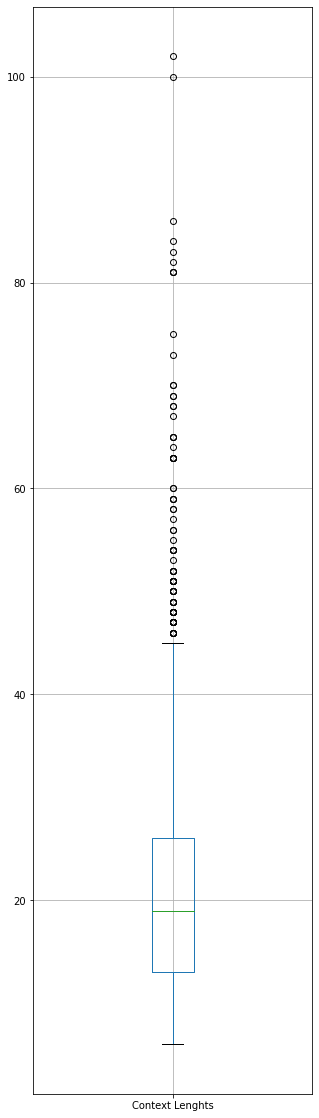

In [ ]:
boxplot = data.boxplot(column=['Context Lenghts'], figsize=(5,20) )

In [ ]:
idioms_train, idioms_test = train_test_split(data['Idiom Normal'], test_size=0.2, random_state=34)

In [ ]:
Y_train.shape

(1359, 2)

### Train & Test

In [ ]:
model_all = build_model()

compiled model


In [ ]:
model_all.fit(X_train_tensor, Y_train, batch_size=8, epochs=10)

Epoch 1/10
170/170 [==============================] - 32s 142ms/step - loss: 0.5983 - accuracy: 0.6887
Epoch 2/10
170/170 [==============================] - 24s 143ms/step - loss: 0.4754 - accuracy: 0.7763
Epoch 3/10
170/170 [==============================] - 24s 143ms/step - loss: 0.4151 - accuracy: 0.8146
Epoch 4/10
170/170 [==============================] - 24s 144ms/step - loss: 0.3586 - accuracy: 0.8344
Epoch 5/10
170/170 [==============================] - 25s 145ms/step - loss: 0.3196 - accuracy: 0.8624
Epoch 6/10
170/170 [==============================] - 25s 145ms/step - loss: 0.2932 - accuracy: 0.8771
Epoch 7/10
170/170 [==============================] - 25s 145ms/step - loss: 0.2639 - accuracy: 0.8911
Epoch 8/10
170/170 [==============================] - 25s 147ms/step - loss: 0.2383 - accuracy: 0.8999
Epoch 9/10
170/170 [==============================] - 25s 145ms/step - loss: 0.2219 - accuracy: 0.9102
Epoch 10/10
170/170 [==============================] - 25s 145ms/step - l

In [ ]:
acc = model_all.evaluate(X_test_tensor, Y_test)[1]
preds = model_all.predict(np.array(X_test_tensor))
f_score = f1_score(np.argmax(preds, axis=1), np.argmax(Y_test, axis=1))
roc_auc = roc_auc_score(Y_test, preds)

print('Accuracy: {}\nF-score: {}\nROC AUC: {}'.format(acc, f_score, roc_auc))
roc_auc_score(Y_test,preds)

11/11 [==============================] - 1s 60ms/step - loss: 0.6532 - accuracy: 0.7853
Accuracy: 0.7852941155433655
F-score: 0.7884057971014493
ROC AUC: 0.864202657807309


0.864202657807309

[[131  41]
 [ 32 136]]


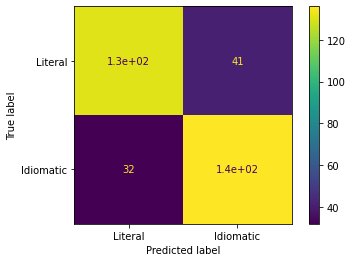

In [ ]:
matrix = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(preds, axis=1))
print(matrix)
disp = ConfusionMatrixDisplay(matrix, display_labels=['Literal', 'Idiomatic'])
disp.plot()

### Best and Worst

#### Function 

In [ ]:
def define_best_and_worst(preds, test, idioms_test, idioms_train, k=10):
  answers = []
  answers_dict = dict(zip(set(idioms_test), [0 for i in np.arange(0, len(set(idioms_test)))]))
  answers_ratios_dict = dict(zip(set(idioms_test), [0 for i in np.arange(0, len(set(idioms_test)))]))
  test_counts = dict(idioms_test.value_counts())
  train_counts = dict(idioms_train.value_counts())
  preds = np.argmax(preds, axis=1)
  test = np.argmax(test, axis=1)
  for i, p in enumerate(preds):
    if p == test[i]:
      answers.append(1)
    else:
      answers.append(0)

  for id, idiom in enumerate(idioms_test):
    if answers[id] == 1: ## if it's correct
      answers_dict[idiom] += 1
  
  for idiom in answers_dict.keys():
    answers_ratios_dict[idiom] = answers_dict[idiom]/test_counts[idiom]

  sorted_answers = sorted(answers_dict.items(), key=lambda x: x[1])
  best_sorted = sorted_answers[:k]
  worst_sorted = sorted_answers[-k:]
  best_sorted_vals = [i[1] for i in best_sorted]
  best_sorted_keys = [i[0] for i in best_sorted]
  worst_sorted_vals = [i[1] for i in worst_sorted]
  worst_sorted_keys = [i[0] for i in worst_sorted]

  best_train_counts = {}
  best_test_counts = {}
  for i in best_sorted:
    best_train_counts[i[0]] = train_counts[i[0]]
    best_test_counts[i[0]] = test_counts[i[0]]

  df = pd.DataFrame({'Количество правильных предсказаний': best_sorted_vals, 
                     'Встречаемость в тренировочных данных': best_train_counts,
                     'Встречаемость в тестовых данных': best_test_counts}, index=best_sorted_keys)
  ax = df.plot.bar(rot=30, figsize=(10,5), color=['#B2BABB', '#616A6B', '#17202A'])

  worst_train_counts = {}
  worst_test_counts = {}
  for i in worst_sorted:
    worst_train_counts[i[0]] = train_counts[i[0]]
    worst_test_counts[i[0]] = test_counts[i[0]]

  df = pd.DataFrame({'Количество правильных предсказаний': worst_sorted_vals, 
                     'Встречаемость в тренировочных данных': worst_train_counts,
                     'Встречаемость в тестовых данных': worst_test_counts}, index=worst_sorted_keys)
  ax = df.plot.bar(rot=30, figsize=(10,5), color=['#B2BABB', '#616A6B', '#17202A'])


In [ ]:
def define_best_and_worst_ratios(preds, test, idioms_test, idioms_train, k=10):
  answers = []
  answers_dict = dict(zip(set(idioms_test), [0 for i in np.arange(0, len(set(idioms_test)))]))
  answers_ratios_dict = dict(zip(set(idioms_test), [0 for i in np.arange(0, len(set(idioms_test)))]))
  test_counts = dict(idioms_test.value_counts())
  train_counts = dict(idioms_train.value_counts())
  preds = np.argmax(preds, axis=1)
  test = np.argmax(test, axis=1)
  for i, p in enumerate(preds):
    if p == test[i]:
      answers.append(1)
    else:
      answers.append(0)

  for id, idiom in enumerate(idioms_test):
    if answers[id] == 1: ## if it's correct
      answers_dict[idiom] += 1
  
  for idiom in answers_dict.keys():
    answers_ratios_dict[idiom] = answers_dict[idiom]/test_counts[idiom]

  sorted_answers = sorted(answers_ratios_dict.items(), key=lambda x: x[1])
  best_sorted = sorted_answers[:k]
  worst_sorted = sorted_answers[-k:]
  best_sorted_vals = [i[1] for i in best_sorted]
  best_sorted_keys = [i[0] for i in best_sorted]
  worst_sorted_vals = [i[1] for i in worst_sorted]
  worst_sorted_keys = [i[0] for i in worst_sorted]

  best_train_counts = {}
  best_test_counts = {}
  for i in best_sorted:
    best_train_counts[i[0]] = train_counts[i[0]]
    best_test_counts[i[0]] = test_counts[i[0]]

  df = pd.DataFrame({'Количество правильных предсказаний': best_sorted_vals, 
                     'Встречаемость в тренировочных данных': best_train_counts,
                     'Встречаемость в тестовых данных': best_test_counts}, index=best_sorted_keys)
  ax = df.plot.bar(rot=30, figsize=(10,5), color=['#B2BABB', '#616A6B', '#17202A'])

  worst_train_counts = {}
  worst_test_counts = {}
  for i in worst_sorted:
    worst_train_counts[i[0]] = train_counts[i[0]]
    worst_test_counts[i[0]] = test_counts[i[0]]

  df = pd.DataFrame({'Количество правильных предсказаний': worst_sorted_vals, 
                     'Встречаемость в тренировочных данных': worst_train_counts,
                     'Встречаемость в тестовых данных': worst_test_counts}, index=worst_sorted_keys)
  ax = df.plot.bar(rot=30, figsize=(10,5), color=['#B2BABB', '#616A6B', '#17202A'])

In [ ]:
def define_best_and_worst_ratios_not_in_train(preds, test, idioms_test, k=10):
  answers = []
  answers_dict = dict(zip(set(idioms_test), [0 for i in np.arange(0, len(set(idioms_test)))]))
  answers_ratios_dict = dict(zip(set(idioms_test), [0 for i in np.arange(0, len(set(idioms_test)))]))
  test_counts = dict(idioms_test.value_counts())
  preds = np.argmax(preds, axis=1)
  test = np.argmax(test, axis=1)
  for i, p in enumerate(preds):
    if p == test[i]:
      answers.append(1)
    else:
      answers.append(0)

  for id, idiom in enumerate(idioms_test):
    if answers[id] == 1: ## if it's correct
      answers_dict[idiom] += 1
  
  for idiom in answers_dict.keys():
    answers_ratios_dict[idiom] = answers_dict[idiom]/test_counts[idiom]

  sorted_answers = sorted(answers_ratios_dict.items(), key=lambda x: x[1])
  best_sorted = sorted_answers[:k]
  worst_sorted = sorted_answers[-k:]
  best_sorted_vals = [i[1] for i in best_sorted]
  best_sorted_keys = [i[0] for i in best_sorted]
  worst_sorted_vals = [i[1] for i in worst_sorted]
  worst_sorted_keys = [i[0] for i in worst_sorted]

  best_test_counts = {}
  for i in best_sorted:
    best_test_counts[i[0]] = test_counts[i[0]]

  df = pd.DataFrame({'Количество правильных предсказаний': best_sorted_vals, 
                     'Встречаемость в тестовых данных': best_test_counts}, index=best_sorted_keys)
  ax = df.plot.bar(rot=30, figsize=(10,5), color=['#B2BABB', '#616A6B', '#17202A'])

  worst_test_counts = {}
  for i in worst_sorted:
    worst_test_counts[i[0]] = test_counts[i[0]]

  df = pd.DataFrame({'Количество правильных предсказаний': worst_sorted_vals, 
                     'Встречаемость в тестовых данных': worst_test_counts}, index=worst_sorted_keys)
  ax = df.plot.bar(rot=30, figsize=(10,5), color=['#B2BABB', '#616A6B', '#17202A'])

In [ ]:
def define_lengths(preds, test, context_lengths_test, k=10):
  answers = []
  answers_dict = dict(zip(set(idioms_test), [0 for i in np.arange(0, len(set(idioms_test)))]))
  answers_ratios_dict = dict(zip(set(idioms_test), [0 for i in np.arange(0, len(set(idioms_test)))]))
  test_counts = dict(idioms_test.value_counts())
  train_counts = dict(idioms_train.value_counts())
  preds = np.argmax(preds, axis=1)
  test = np.argmax(test, axis=1)
  trues = []
  falses = []
  for i, p in enumerate(preds):
    if p == test[i]:
      answers.append(1)
      trues.append(context_lengths_test[i])
    else:
      answers.append(0)
      falses.append(context_lengths_test[i])

  df = pd.DataFrame({'Истинные предсказания': trues})
  hist = df.hist(bins=35, figsize=(10,2), color='gray')

  df = pd.DataFrame({'Ложные предсказания': falses})
  hist = df.hist(bins=35, figsize=(10,2), color='gray')
  
  print(len(trues), len(falses))
  #create a df
  #df['True'] = trues
  #df['False'] = falses
  #ax = df.plot.hist(bins=12, alpha=0.5)

267 73


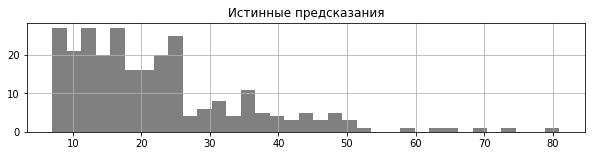

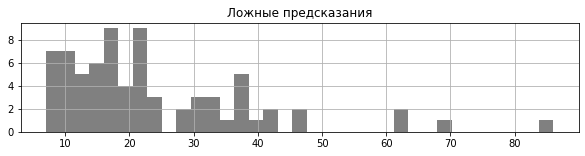

In [ ]:
define_lengths(preds, Y_test, context_lengths_test)

#### Plots

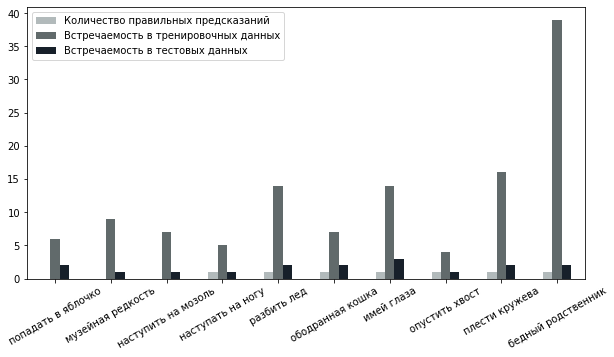

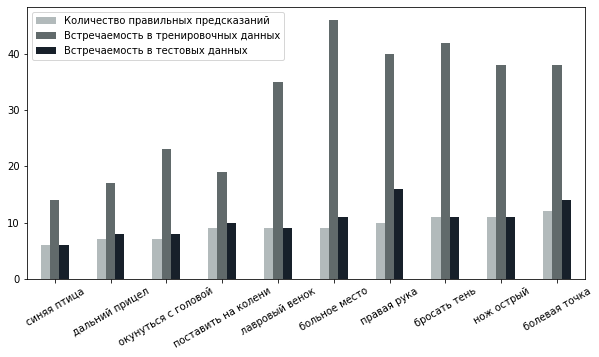

In [ ]:
define_best_and_worst(preds, Y_test, idioms_test, idioms_train)

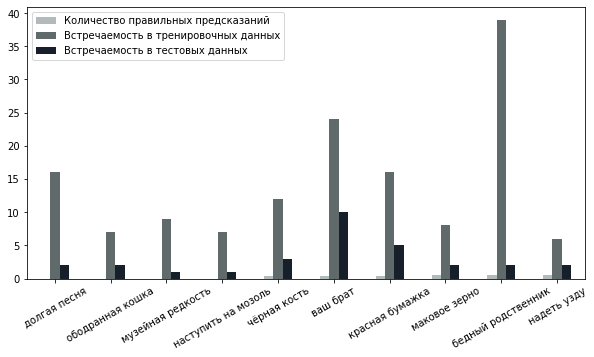

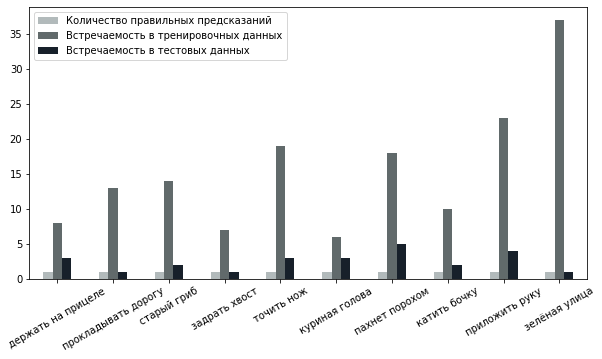

In [ ]:
define_best_and_worst_ratios(preds, Y_test, idioms_test, idioms_train)

#### Split 7/3

In [ ]:
X_train, X_test = train_test_split(embedded_contexts, test_size=0.3, random_state=34)
Y_train, Y_test = train_test_split(labels, test_size=0.3, random_state=34)
X_train_tensor = tf.convert_to_tensor(X_train)
X_test_tensor = tf.convert_to_tensor(X_test)

In [ ]:
model_all_2 = build_model()

compiled model


In [ ]:
model_all_2.fit(X_train_tensor, Y_train, batch_size=8, epochs=10)

Epoch 1/10
149/149 [==============================] - 35s 152ms/step - loss: 0.6065 - accuracy: 0.6745
Epoch 2/10
149/149 [==============================] - 22s 147ms/step - loss: 0.4733 - accuracy: 0.7780
Epoch 3/10
149/149 [==============================] - 24s 159ms/step - loss: 0.4261 - accuracy: 0.8040
Epoch 4/10
149/149 [==============================] - 22s 148ms/step - loss: 0.3775 - accuracy: 0.8343
Epoch 5/10
149/149 [==============================] - 22s 147ms/step - loss: 0.3412 - accuracy: 0.8537
Epoch 6/10
149/149 [==============================] - 23s 152ms/step - loss: 0.3039 - accuracy: 0.8780
Epoch 7/10
149/149 [==============================] - 23s 156ms/step - loss: 0.2690 - accuracy: 0.8873
Epoch 8/10
149/149 [==============================] - 23s 154ms/step - loss: 0.2400 - accuracy: 0.9092
Epoch 9/10
149/149 [==============================] - 23s 157ms/step - loss: 0.2202 - accuracy: 0.9100
Epoch 10/10
149/149 [==============================] - 23s 155ms/step - l

In [ ]:
model_all_2.evaluate(X_test_tensor, Y_test)

16/16 [==============================] - 4s 68ms/step - loss: 0.6396 - accuracy: 0.8059


[0.6395891308784485, 0.8058823347091675]

In [ ]:
preds_all = model_all_2.predict(np.array(X_test_tensor))
f1_score(np.argmax(preds_all, axis=1), np.argmax(Y_test, axis=1))

0.8216216216216216

## VNC

In [ ]:
embedded_contexts_vnc = get_bert_embeddings(data_vnc['Example'])

In [ ]:
labels_vnc = to_categorical(data_vnc.Label)
X_train_vnc, X_test_vnc = train_test_split(embedded_contexts_vnc, test_size=0.2, random_state=34)
Y_train_vnc, Y_test_vnc = train_test_split(labels_vnc, test_size=0.2, random_state=34)
X_train_vnc = tf.convert_to_tensor(X_train_vnc)
X_test_vnc = tf.convert_to_tensor(X_test_vnc)

### Train & Test

In [ ]:
model_vnc = build_model()

compiled model


In [ ]:
model_vnc.fit(X_train_vnc, Y_train_vnc, batch_size=8, epochs=10)

Epoch 1/10
90/90 [==============================] - 18s 136ms/step - loss: 0.6230 - accuracy: 0.6737
Epoch 2/10
90/90 [==============================] - 12s 134ms/step - loss: 0.4568 - accuracy: 0.7997
Epoch 3/10
90/90 [==============================] - 12s 135ms/step - loss: 0.3641 - accuracy: 0.8473
Epoch 4/10
90/90 [==============================] - 12s 135ms/step - loss: 0.3199 - accuracy: 0.8725
Epoch 5/10
90/90 [==============================] - 12s 134ms/step - loss: 0.2799 - accuracy: 0.8894
Epoch 6/10
90/90 [==============================] - 12s 136ms/step - loss: 0.2314 - accuracy: 0.9034
Epoch 7/10
90/90 [==============================] - 12s 134ms/step - loss: 0.1935 - accuracy: 0.9286
Epoch 8/10
90/90 [==============================] - 12s 135ms/step - loss: 0.1753 - accuracy: 0.9384
Epoch 9/10
90/90 [==============================] - 12s 135ms/step - loss: 0.1257 - accuracy: 0.9552
Epoch 10/10
90/90 [==============================] - 12s 134ms/step - loss: 0.1046 - accura

In [ ]:
acc = model_vnc.evaluate(X_test_vnc, Y_test_vnc)[1]
preds = model_vnc.predict(np.array(X_test_vnc))
f_score = f1_score(np.argmax(preds, axis=1), np.argmax(Y_test_vnc, axis=1))
roc_auc = roc_auc_score(Y_test_vnc, preds)

print('Accuracy: {}\nF-score: {}\nROC AUC: {}'.format(acc, f_score, roc_auc))
roc_auc_score(Y_test_vnc,preds)

6/6 [==============================] - 0s 52ms/step - loss: 0.5874 - accuracy: 0.8212
Accuracy: 0.8212290406227112
F-score: 0.8202247191011236
ROC AUC: 0.9297032828282827


0.9297032828282827

[[74  6]
 [26 73]]


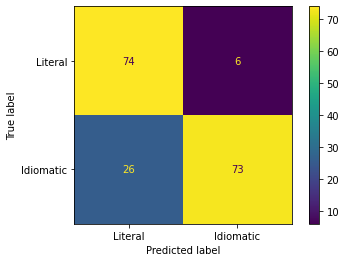

In [ ]:
matrix = confusion_matrix(np.argmax(Y_test_vnc, axis=1), np.argmax(preds, axis=1))
print(matrix)
disp = ConfusionMatrixDisplay(matrix, display_labels=['Literal', 'Idiomatic'])
disp.plot()

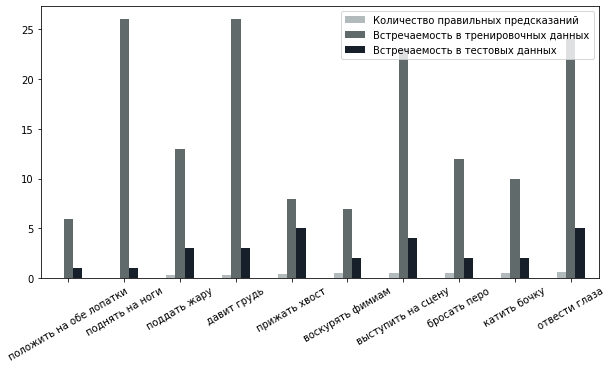

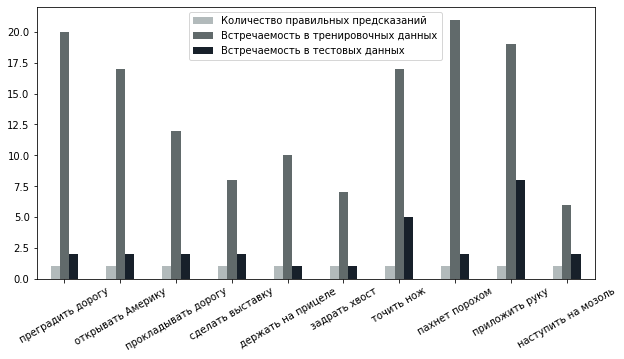

In [ ]:
idioms_train_vnc, idioms_test_vnc = train_test_split(data_vnc['Idiom Normal'], test_size=0.2, random_state=34)
define_best_and_worst_ratios(preds, Y_test_vnc, idioms_test_vnc, idioms_train_vnc)

#### Split 7/3

In [ ]:
X_train_vnc, X_test_vnc = train_test_split(embedded_contexts_vnc, test_size=0.3, random_state=34)
Y_train_vnc, Y_test_vnc = train_test_split(labels_vnc, test_size=0.3, random_state=34)
X_train_vnc = tf.convert_to_tensor(X_train_vnc)
X_test_vnc = tf.convert_to_tensor(X_test_vnc)

In [ ]:
model_vnc_2 = build_model()
model_vnc_2.fit(X_train_vnc, Y_train_vnc, batch_size=8, epochs=10)

compiled model
Epoch 1/10
79/79 [==============================] - 19s 145ms/step - loss: 0.6290 - accuracy: 0.6816
Epoch 2/10
79/79 [==============================] - 12s 147ms/step - loss: 0.4771 - accuracy: 0.8048
Epoch 3/10
79/79 [==============================] - 12s 152ms/step - loss: 0.3887 - accuracy: 0.8464
Epoch 4/10
79/79 [==============================] - 12s 149ms/step - loss: 0.3298 - accuracy: 0.8608
Epoch 5/10
79/79 [==============================] - 12s 148ms/step - loss: 0.2670 - accuracy: 0.8960
Epoch 6/10
79/79 [==============================] - 12s 151ms/step - loss: 0.2427 - accuracy: 0.9040
Epoch 7/10
79/79 [==============================] - 13s 161ms/step - loss: 0.1919 - accuracy: 0.9328
Epoch 8/10
79/79 [==============================] - 12s 157ms/step - loss: 0.1707 - accuracy: 0.9408
Epoch 9/10
79/79 [==============================] - 12s 153ms/step - loss: 0.1475 - accuracy: 0.9504
Epoch 10/10
79/79 [==============================] - 12s 156ms/step - loss: 

In [ ]:
model_vnc_2.evaluate(X_test_vnc, Y_test_vnc)

9/9 [==============================] - 3s 64ms/step - loss: 0.4609 - accuracy: 0.8321


[0.4609304666519165, 0.8320895433425903]

In [ ]:
preds_vnc = model_vnc_2.predict(np.array(X_test_vnc))
f1_score(np.argmax(preds_vnc, axis=1), np.argmax(Y_test_vnc, axis=1))

0.8484848484848485

## ANC

In [ ]:
embedded_contexts_anc = get_bert_embeddings(data_anc['Example'])

In [ ]:
labels_anc = to_categorical(data_anc.Label)
X_train_anc, X_test_anc = train_test_split(embedded_contexts_anc, test_size=0.2, random_state=34)
Y_train_anc, Y_test_anc = train_test_split(labels_anc, test_size=0.2, random_state=34)
X_train_anc = tf.convert_to_tensor(X_train_anc)
X_test_anc = tf.convert_to_tensor(X_test_anc)

### Classifier

In [ ]:
model_anc = build_model()

compiled model


In [ ]:
model_anc.fit(np.asarray(X_train_anc), Y_train_anc, batch_size=8, epochs=10)
print('fit model')

Epoch 1/10
81/81 [==============================] - 17s 133ms/step - loss: 0.6709 - accuracy: 0.6196
Epoch 2/10
81/81 [==============================] - 11s 133ms/step - loss: 0.5687 - accuracy: 0.7174
Epoch 3/10
81/81 [==============================] - 11s 136ms/step - loss: 0.4915 - accuracy: 0.7748
Epoch 4/10
81/81 [==============================] - 11s 134ms/step - loss: 0.4231 - accuracy: 0.8121
Epoch 5/10
81/81 [==============================] - 11s 134ms/step - loss: 0.3804 - accuracy: 0.8292
Epoch 6/10
81/81 [==============================] - 11s 133ms/step - loss: 0.3141 - accuracy: 0.8758
Epoch 7/10
81/81 [==============================] - 11s 134ms/step - loss: 0.2834 - accuracy: 0.8742
Epoch 8/10
81/81 [==============================] - 11s 133ms/step - loss: 0.2498 - accuracy: 0.8944
Epoch 9/10
81/81 [==============================] - 11s 134ms/step - loss: 0.2047 - accuracy: 0.9193
Epoch 10/10
81/81 [==============================] - 11s 135ms/step - loss: 0.1878 - accura

In [ ]:
acc = model_anc.evaluate(X_test_anc, Y_test_anc)[1]
preds = model_anc.predict(np.array(X_test_anc))
f_score = f1_score(np.argmax(preds, axis=1), np.argmax(Y_test_anc, axis=1))
roc_auc = roc_auc_score(Y_test_anc, preds)

print('Accuracy: {}\nF-score: {}\nROC AUC: {}'.format(acc, f_score, roc_auc))
roc_auc_score(Y_test_anc,preds)

6/6 [==============================] - 2s 52ms/step - loss: 0.8447 - accuracy: 0.7346
Accuracy: 0.7345678806304932
F-score: 0.6666666666666667
ROC AUC: 0.8266178266178266


0.8266178266178266

[[76  8]
 [35 43]]


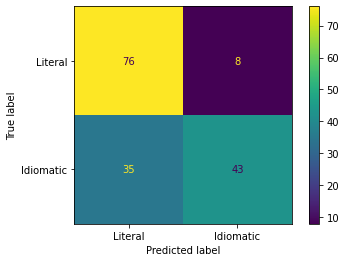

In [ ]:
matrix = confusion_matrix(np.argmax(Y_test_anc, axis=1), np.argmax(preds, axis=1))
print(matrix)
disp = ConfusionMatrixDisplay(matrix, display_labels=['Literal', 'Idiomatic'])
disp.plot()

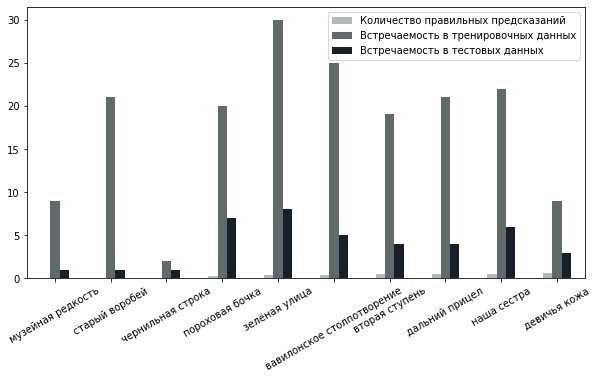

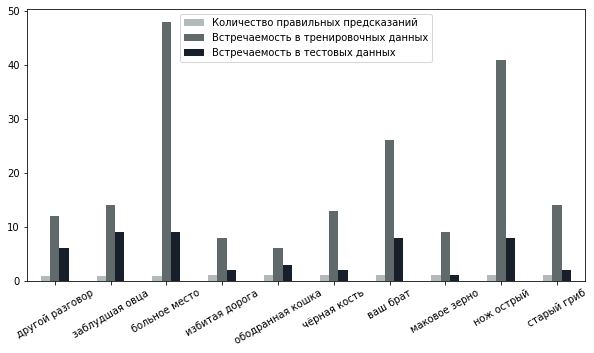

In [ ]:
idioms_train_anc, idioms_test_anc = train_test_split(data_anc['Idiom Normal'], test_size=0.2, random_state=34)
define_best_and_worst_ratios(preds, Y_test_anc, idioms_test_anc, idioms_train_anc)

#### Split 7/3

In [ ]:
X_train_anc, X_test_anc = train_test_split(embedded_contexts_anc, test_size=0.3, random_state=34)
Y_train_anc, Y_test_anc = train_test_split(labels_anc, test_size=0.3, random_state=34)
X_train_anc = tf.convert_to_tensor(X_train_anc)
X_test_anc = tf.convert_to_tensor(X_test_anc)

In [ ]:
model_anc_2 = build_model()
model_anc_2.fit(np.asarray(X_train_anc), Y_train_anc, batch_size=8, epochs=10)

compiled model
Epoch 1/10
71/71 [==============================] - 19s 157ms/step - loss: 0.6817 - accuracy: 0.5816
Epoch 2/10
71/71 [==============================] - 10s 142ms/step - loss: 0.5615 - accuracy: 0.7376
Epoch 3/10
71/71 [==============================] - 10s 140ms/step - loss: 0.4865 - accuracy: 0.7784
Epoch 4/10
71/71 [==============================] - 10s 140ms/step - loss: 0.4246 - accuracy: 0.8014
Epoch 5/10
71/71 [==============================] - 10s 141ms/step - loss: 0.3675 - accuracy: 0.8440
Epoch 6/10
71/71 [==============================] - 11s 148ms/step - loss: 0.3139 - accuracy: 0.8777
Epoch 7/10
71/71 [==============================] - 11s 150ms/step - loss: 0.2552 - accuracy: 0.8901
Epoch 8/10
71/71 [==============================] - 10s 146ms/step - loss: 0.2133 - accuracy: 0.9184
Epoch 9/10
71/71 [==============================] - 10s 147ms/step - loss: 0.1969 - accuracy: 0.9255
Epoch 10/10
71/71 [==============================] - 10s 145ms/step - loss: 

In [ ]:
model_anc_2.evaluate(np.asarray(X_test_anc), Y_test_anc)

8/8 [==============================] - 4s 86ms/step - loss: 0.8006 - accuracy: 0.7562


[0.8005598783493042, 0.7561983466148376]

In [ ]:
preds_anc = model_anc_2.predict(np.array(X_test_anc))
f1_score(np.argmax(preds_anc, axis=1), np.argmax(Y_test_anc, axis=1))

0.7773584905660378

# Trained on one type, tested on another

## VNC --> ANC

In [ ]:
acc = model_vnc.evaluate(X_test_anc, Y_test_anc)[1]
preds = model_vnc.predict(np.array(X_test_anc))
f_score = f1_score(np.argmax(preds, axis=1), np.argmax(Y_test_anc, axis=1))
roc_auc = roc_auc_score(Y_test_anc, preds)

print('Accuracy: {}\nF-score: {}\nROC AUC: {}'.format(acc, f_score, roc_auc))
roc_auc_score(Y_test_anc,preds)

6/6 [==============================] - 0s 47ms/step - loss: 1.0188 - accuracy: 0.7284
Accuracy: 0.7283950448036194
F-score: 0.7066666666666668
ROC AUC: 0.7822802197802198


0.7822802197802198

[[65 19]
 [25 53]]


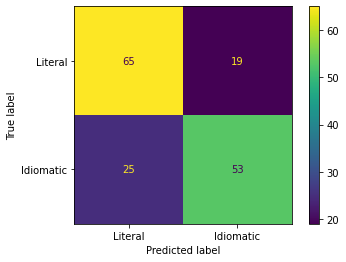

In [ ]:
matrix = confusion_matrix(np.argmax(Y_test_anc, axis=1), np.argmax(preds, axis=1))
print(matrix)
disp = ConfusionMatrixDisplay(matrix, display_labels=['Literal', 'Idiomatic'])
disp.plot()

## VNC --> VNC + ANC

In [ ]:
acc = model_vnc.evaluate(X_test_tensor, Y_test)[1]
preds = model_vnc.predict(np.array(X_test_tensor))
f_score = f1_score(np.argmax(preds, axis=1), np.argmax(Y_test, axis=1))
roc_auc = roc_auc_score(Y_test, preds_all)

print('Accuracy: {}\nF-score: {}\nROC AUC: {}'.format(acc, f_score, roc_auc))
roc_auc_score(Y_test,preds_all)

11/11 [==============================] - 1s 54ms/step - loss: 0.5645 - accuracy: 0.8559
Accuracy: 0.8558823466300964
F-score: 0.8434504792332268
ROC AUC: 0.8729235880398671


0.8729235880398671

[[159  13]
 [ 36 132]]


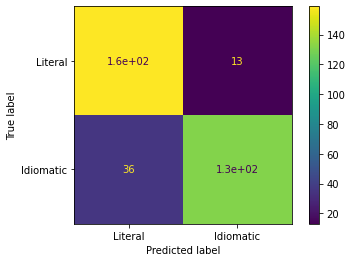

In [ ]:
matrix = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(preds, axis=1))
print(matrix)
disp = ConfusionMatrixDisplay(matrix, display_labels=['Literal', 'Idiomatic'])
disp.plot()

## ANC --> VNC

In [ ]:
acc = model_anc.evaluate(X_test_vnc, Y_test_vnc)[1]
preds = model_anc.predict(np.array(X_test_vnc))
f_score = f1_score(np.argmax(preds, axis=1), np.argmax(Y_test_vnc, axis=1))
roc_auc = roc_auc_score(Y_test_vnc, preds)

print('Accuracy: {}\nF-score: {}\nROC AUC: {}'.format(acc, f_score, roc_auc))
roc_auc_score(Y_test_vnc,preds)

6/6 [==============================] - 0s 53ms/step - loss: 0.9667 - accuracy: 0.6369
Accuracy: 0.6368715167045593
F-score: 0.5695364238410595
ROC AUC: 0.8151830808080809


0.8151830808080809

[[71  9]
 [56 43]]


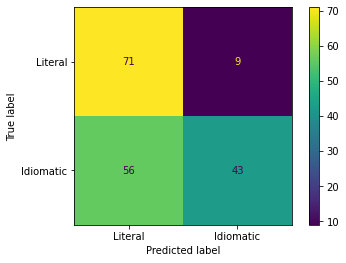

In [ ]:
matrix = confusion_matrix(np.argmax(Y_test_vnc, axis=1), np.argmax(preds, axis=1))
print(matrix)
disp = ConfusionMatrixDisplay(matrix, display_labels=['Literal', 'Idiomatic'])
disp.plot()

## ANC --> ANC + VNC

In [ ]:
acc = model_anc.evaluate(X_test_tensor, Y_test)[1]
preds = model_anc.predict(np.array(X_test_tensor))
f_score = f1_score(np.argmax(preds, axis=1), np.argmax(Y_test, axis=1))
roc_auc = roc_auc_score(Y_test, preds_all)

print('Accuracy: {}\nF-score: {}\nROC AUC: {}'.format(acc, f_score, roc_auc))
roc_auc_score(Y_test,preds_all)

11/11 [==============================] - 1s 55ms/step - loss: 0.6310 - accuracy: 0.7794
Accuracy: 0.779411792755127
F-score: 0.7422680412371134
ROC AUC: 0.8729235880398671


0.8729235880398671

[[157  15]
 [ 60 108]]


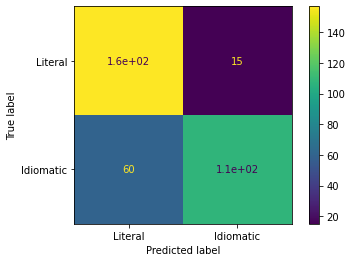

In [ ]:
matrix = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(preds, axis=1))
print(matrix)
disp = ConfusionMatrixDisplay(matrix, display_labels=['Literal', 'Idiomatic'])
disp.plot()

# Not Present in the Training Set

## Split

In [ ]:
data_anc['Idiom Normal'].value_counts()

больное место                 57
правая рука                   56
болевая точка                 52
нож острый                    49
путеводная звезда             48
лавровый венок                44
бедный родственник            41
зелёная улица                 38
тяжёлая рука                  38
ваш брат                      34
вавилонское столпотворение    30
наша сестра                   28
пороховая бочка               27
дальний прицел                25
вторая ступень                23
заблудшая овца                23
старый воробей                22
красная бумажка               21
синяя птица                   20
другой разговор               18
долгая песня                  18
старый гриб                   16
чёрная кость                  15
девичья кожа                  12
маковое зерно                 10
избитая дорога                10
музейная редкость             10
куриная голова                 9
ободранная кошка               9
чернильная строка              3
Name: Idio

In [ ]:
test_ancs = ['вавилонское столпотворение', 'ободранная кошка', 'наша сестра', 'пороховая бочка', 'дальний прицел', 'заблудшая овца', 'красная бумажка']

In [ ]:
data_anc_test = data_anc.loc[data_anc['Idiom Normal'].isin(test_ancs)]
data_anc_test = data_anc_test.sample(frac=1, random_state=42)
data_anc_test.shape

(163, 5)

In [ ]:
data_anc_train = data_anc.loc[~data_anc['Idiom Normal'].isin(test_ancs)]
data_anc_train = data_anc_train.sample(frac=1, random_state=42)
data_anc_train.shape

(643, 5)

In [ ]:
163/806

0.2022332506203474

In [ ]:
data_vnc['Idiom Normal'].value_counts()

бросать тень               53
сесть на мель              47
пускать корни              41
окунуться с головой        31
отвести глаза              29
поставить на колени        29
давит грудь                29
снимать шляпу              27
приложить руку             27
выступить на сцену         27
поднять на ноги            27
положить голову            25
пахнет порохом             23
вырвать с корнем           23
точить нож                 22
преградить дорогу          22
вильнуть хвостом           21
сидеть на печи             20
открыть глаза              20
открывать Америку          19
умывать руки               19
плести кружева             18
имей глаза                 17
взваливать на плечи        17
поддать жару               16
чесать затылок             16
разбить лед                16
бросать перо               14
прокладывать дорогу        14
давать сдачу               13
прижать хвост              13
прищемить хвост            12
катить бочку               12
поймать на

In [ ]:
test_vncs = ['точить нож', 'преградить дорогу', 'вильнуть хвостом', 'сидеть на печи', 
             'открыть глаза', 'умывать руки', 'открывать Америку', 'плести кружева', 
             'положить голову']

In [ ]:
data_vnc_test = data_vnc.loc[data_vnc['Idiom Normal'].isin(test_vncs)]
data_vnc_test = data_vnc_test.sample(frac=1, random_state=42)
data_vnc_test.shape

(186, 5)

In [ ]:
data_vnc_train = data_vnc.loc[~data_vnc['Idiom Normal'].isin(test_ancs)]
data_vnc_train = data_vnc_train.sample(frac=1, random_state=42)
data_vnc_train.shape

(893, 5)

In [ ]:
186/893

0.20828667413213886

In [ ]:
data_all_train = pd.concat([data_vnc_train, data_anc_train], ignore_index=True)
data_all_train = data_all_train.sample(frac=1, random_state=42)
data_all_train.head(2)

,Idiom Normal,Idiom Inflected,Label,Example,ID
1159,тяжёлая рука,тяжёлую руку,0,"Однажды, когда цесаревич до крови разбил коле...",530
76,положить на обе лопатки,положили на обе лопатки,1,― Сдаюсь! Положили на обе лопатки. Но работе...,1574


In [ ]:
data_all_test = pd.concat([data_vnc_test, data_anc_test], ignore_index=True)
data_all_test = data_all_test.sample(frac=1, random_state=42)
data_all_test.head(2)

,Idiom Normal,Idiom Inflected,Label,Example,ID
157,преградить дорогу,преградить дорогу,0,Что если кому-нибудь из ваших анархистов приде...,1159
341,наша сестра,нашей сестры,0,У нашей сестры Марии Павловны была подруга Ли...,723


## All

In [ ]:
embedded_contexts_train = get_bert_embeddings(data_all_train['Example'])

In [ ]:
embedded_contexts_test = get_bert_embeddings(data_all_test['Example'])

In [ ]:
labels_train_not_present = to_categorical(data_all_train.Label)
labels_test_not_present = to_categorical(data_all_test.Label)

### Classifier

In [ ]:
embedded_contexts_train = tf.convert_to_tensor(embedded_contexts_train)
embedded_contexts_test = tf.convert_to_tensor(embedded_contexts_test)

In [ ]:
model_all_3 = build_model()
model_all_3.fit(embedded_contexts_train, labels_train_not_present, batch_size=8, epochs=10)

compiled model
Epoch 1/10
192/192 [==============================] - 22s 95ms/step - loss: 0.5926 - accuracy: 0.6934
Epoch 2/10
192/192 [==============================] - 18s 94ms/step - loss: 0.4524 - accuracy: 0.8034
Epoch 3/10
192/192 [==============================] - 18s 94ms/step - loss: 0.3854 - accuracy: 0.8262
Epoch 4/10
192/192 [==============================] - 18s 95ms/step - loss: 0.3527 - accuracy: 0.8516
Epoch 5/10
192/192 [==============================] - 18s 95ms/step - loss: 0.3121 - accuracy: 0.8665
Epoch 6/10
192/192 [==============================] - 18s 94ms/step - loss: 0.2899 - accuracy: 0.8783
Epoch 7/10
192/192 [==============================] - 18s 94ms/step - loss: 0.2406 - accuracy: 0.9069
Epoch 8/10
192/192 [==============================] - 18s 95ms/step - loss: 0.2195 - accuracy: 0.9095
Epoch 9/10
192/192 [==============================] - 18s 95ms/step - loss: 0.2077 - accuracy: 0.9212
Epoch 10/10
192/192 [==============================] - 18s 95ms/ste

In [ ]:
acc = model_all_3.evaluate(embedded_contexts_test, labels_test_not_present)[1]
preds = model_all_3.predict(np.array(embedded_contexts_test))
f_score = f1_score(np.argmax(preds, axis=1), np.argmax(labels_test_not_present, axis=1))
roc_auc = roc_auc_score(labels_test_not_present, preds)

print('Accuracy: {}\nF-score: {}\nROC AUC: {}'.format(acc, f_score, roc_auc))
roc_auc_score(labels_test_not_present,preds)

11/11 [==============================] - 1s 56ms/step - loss: 0.6005 - accuracy: 0.8223
Accuracy: 0.8223495483398438
F-score: 0.8238636363636364
ROC AUC: 0.8778746961035547


0.8778746961035547

[[142  29]
 [ 33 145]]


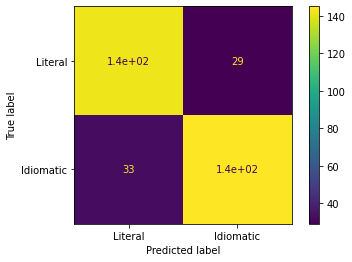

In [ ]:
matrix = confusion_matrix(np.argmax(labels_test_not_present, axis=1), np.argmax(preds, axis=1))
print(matrix)
disp = ConfusionMatrixDisplay(matrix, display_labels=['Literal', 'Idiomatic'])
disp.plot()

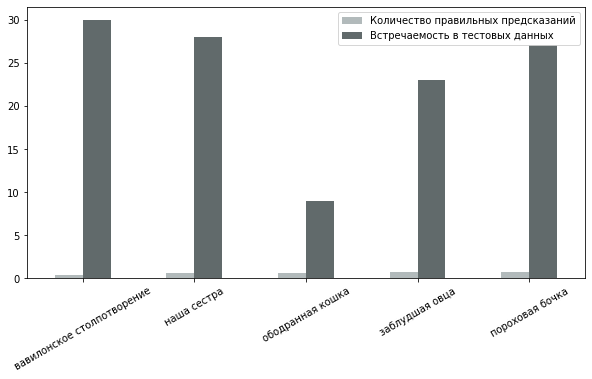

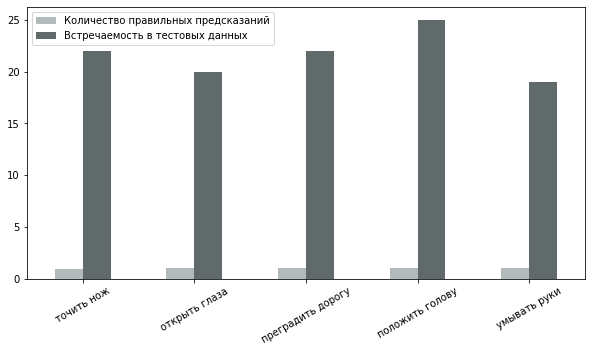

In [ ]:
idioms_test_not_present = data_all_test['Idiom Normal']
define_best_and_worst_ratios_not_in_train(preds, labels_test_not_present, idioms_test_not_present, k=5)

## ANC

In [ ]:
embedded_contexts_anc_train = get_bert_embeddings(data_anc_train['Example'])

In [ ]:
embedded_contexts_anc_test = get_bert_embeddings(data_anc_test['Example'])

In [ ]:
labels_anc_train_not_present = to_categorical(data_anc_train.Label)
labels_anc_test_not_present = to_categorical(data_anc_test.Label)

### Classifier

In [ ]:
embedded_contexts_anc_train = tf.convert_to_tensor(embedded_contexts_anc_train)
embedded_contexts_anc_test = tf.convert_to_tensor(embedded_contexts_anc_test)

In [ ]:
model_anc_3 = build_model()
model_anc_3.fit(embedded_contexts_anc_train, labels_anc_train_not_present, batch_size=8, epochs=10)

compiled model
Epoch 1/10
81/81 [==============================] - 17s 137ms/step - loss: 0.6538 - accuracy: 0.6096
Epoch 2/10
81/81 [==============================] - 11s 135ms/step - loss: 0.5352 - accuracy: 0.7621
Epoch 3/10
81/81 [==============================] - 11s 136ms/step - loss: 0.4412 - accuracy: 0.8025
Epoch 4/10
81/81 [==============================] - 11s 135ms/step - loss: 0.3676 - accuracy: 0.8414
Epoch 5/10
81/81 [==============================] - 11s 135ms/step - loss: 0.3164 - accuracy: 0.8585
Epoch 6/10
81/81 [==============================] - 11s 136ms/step - loss: 0.2756 - accuracy: 0.9005
Epoch 7/10
81/81 [==============================] - 11s 135ms/step - loss: 0.2601 - accuracy: 0.8911
Epoch 8/10
81/81 [==============================] - 11s 135ms/step - loss: 0.2006 - accuracy: 0.9191
Epoch 9/10
81/81 [==============================] - 11s 135ms/step - loss: 0.1725 - accuracy: 0.9362
Epoch 10/10
81/81 [==============================] - 11s 136ms/step - loss: 

In [ ]:
acc = model_anc_3.evaluate(embedded_contexts_anc_test, labels_anc_test_not_present)[1]
preds = model_anc_3.predict(np.array(embedded_contexts_anc_test))
f_score = f1_score(np.argmax(preds, axis=1), np.argmax(labels_anc_test_not_present, axis=1))
roc_auc = roc_auc_score(labels_anc_test_not_present, preds)

print('Accuracy: {}\nF-score: {}\nROC AUC: {}'.format(acc, f_score, roc_auc))
roc_auc_score(labels_anc_test_not_present,preds)

6/6 [==============================] - 0s 51ms/step - loss: 1.2416 - accuracy: 0.5951
Accuracy: 0.5950919985771179
F-score: 0.6526315789473685
ROC AUC: 0.6325719960278053


0.6325719960278053

[[35 22]
 [44 62]]


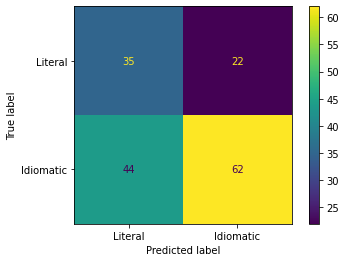

In [ ]:
matrix = confusion_matrix(np.argmax(labels_anc_test_not_present, axis=1), np.argmax(preds, axis=1))
print(matrix)
disp = ConfusionMatrixDisplay(matrix, display_labels=['Literal', 'Idiomatic'])
disp.plot()

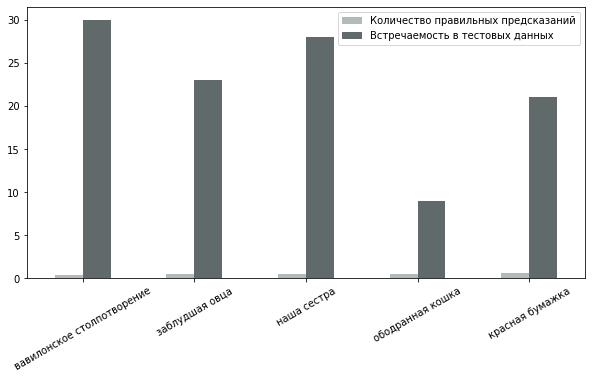

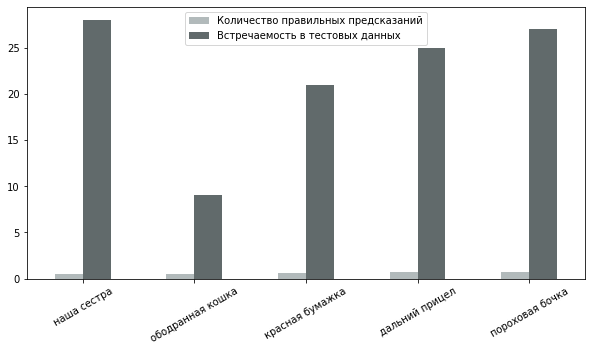

In [ ]:
idioms_test_not_present = data_anc_test['Idiom Normal']
define_best_and_worst_ratios_not_in_train(preds, labels_anc_test_not_present, idioms_test_not_present, k=5)

In [ ]:
data_anc_test['Idiom Normal'].value_counts()

вавилонское столпотворение    30
наша сестра                   28
пороховая бочка               27
дальний прицел                25
заблудшая овца                23
красная бумажка               21
ободранная кошка               9
Name: Idiom Normal, dtype: int64

## VNC

In [ ]:
embedded_contexts_vnc_train = get_bert_embeddings(data_vnc_train['Example'])

In [ ]:
embedded_contexts_vnc_test = get_bert_embeddings(data_vnc_test['Example'])

In [ ]:
labels_vnc_train_not_present = to_categorical(data_vnc_train.Label)
labels_vnc_test_not_present = to_categorical(data_vnc_test.Label)

In [ ]:
data_vnc_train

,Idiom Normal,Idiom Inflected,Label,Example
710,окунуться с головой,окунуться с головой,1,Но Андрею хотелось иметь диплом и скорее окун...
440,сесть на мель,села на мель,1,"Фирма села на мель, а завод по недосмотру сго..."
525,поднять на ноги,поднял на ноги,0,"Лидянг схватил за руку Оленегонку, поднял на..."
721,окунуться с головой,окунулся с головой,1,"С началом строительства БАМа, Николай окунулс..."
39,бросать тень,бросал тень,1,И хотя вряд ли в северной деревне могли догад...
...,...,...,...,...
106,выступить на сцену,выступила на сцену,0,"Как бы то ни было, кому-то это не понравилось..."
270,прищемить хвост,прищемили хвост,0,"― Что, сильно прищемили хвост, бедная моя са..."
860,взваливать на плечи,взваливал на плечи,0,― кричал дворник. Шарманщик суетливо взвали...
435,сесть на мель,сел на мель,0,"Но, как оказалось, вывести его оттуда не удал..."


In [ ]:
data_vnc_test

,Idiom Normal,Idiom Inflected,Label,Example
688,умывать руки,умывать руки,1,"Решение 1869 года за № 724, окончательно уста..."
788,открыть глаза,откроют глаза,1,"Пусть наши дети и внуки, думал он, учат грамо..."
865,сидеть на печи,сидеть на печи,0,Сидеть на печи всегда было уютно и радостно.
617,вильнуть хвостом,вильнул хвостом,0,Тогда я открыл дверь и пригласил его войти в ...
616,вильнуть хвостом,вильнул хвостом,0,"Рекс подошел к камушку, понюхал круглый гости..."
...,...,...,...,...
622,вильнуть хвостом,вильнёт хвостом,1,"И до того он как-то всем рыбам надоел, что н..."
218,открывать Америку,открывал Америку,0,"Когда Колумб открывал Америку, в мире жили об..."
608,вильнуть хвостом,вильнуть хвостом,1,А иные ловкачи и там и сям успеют вильнуть хво...
875,сидеть на печи,сидела на печи,0,"Его дочь, та самая девочка, которая сидела на..."


### Classifier

In [ ]:
embedded_contexts_vnc_train = tf.convert_to_tensor(embedded_contexts_vnc_train)
embedded_contexts_vnc_test = tf.convert_to_tensor(embedded_contexts_vnc_test)

In [ ]:
model_vnc_3 = build_model()
model_vnc_3.fit(embedded_contexts_vnc_train, labels_vnc_train_not_present, batch_size=8, epochs=10)

compiled model
Epoch 1/10
112/112 [==============================] - 21s 138ms/step - loss: 0.5875 - accuracy: 0.7111
Epoch 2/10
112/112 [==============================] - 15s 137ms/step - loss: 0.4246 - accuracy: 0.8219
Epoch 3/10
112/112 [==============================] - 15s 136ms/step - loss: 0.3431 - accuracy: 0.8623
Epoch 4/10
112/112 [==============================] - 15s 136ms/step - loss: 0.2976 - accuracy: 0.8824
Epoch 5/10
112/112 [==============================] - 15s 137ms/step - loss: 0.2574 - accuracy: 0.8914
Epoch 6/10
112/112 [==============================] - 15s 135ms/step - loss: 0.2198 - accuracy: 0.9138
Epoch 7/10
112/112 [==============================] - 15s 135ms/step - loss: 0.1840 - accuracy: 0.9283
Epoch 8/10
112/112 [==============================] - 15s 134ms/step - loss: 0.1615 - accuracy: 0.9384
Epoch 9/10
112/112 [==============================] - 15s 135ms/step - loss: 0.1340 - accuracy: 0.9440
Epoch 10/10
112/112 [==============================] - 15s

In [ ]:
model_vnc_3.evaluate(np.asarray(embedded_contexts_vnc_test), labels_vnc_test_not_present)
                     
acc = model_vnc_3.evaluate(embedded_contexts_vnc_test, labels_vnc_test_not_present)[1]
preds = model_vnc_3.predict(np.array(embedded_contexts_vnc_test))
f_score = f1_score(np.argmax(preds, axis=1), np.argmax(labels_vnc_test_not_present, axis=1))
roc_auc = roc_auc_score(labels_vnc_test_not_present, preds)

print('Accuracy: {}\nF-score: {}\nROC AUC: {}'.format(acc, f_score, roc_auc))
roc_auc_score(labels_vnc_test_not_present,preds)

6/6 [==============================] - 0s 58ms/step - loss: 0.0526 - accuracy: 0.9839
Accuracy: 0.9838709831237793
F-score: 0.979020979020979
ROC AUC: 0.9980506822612085


0.9980506822612085

[[113   1]
 [  2  70]]


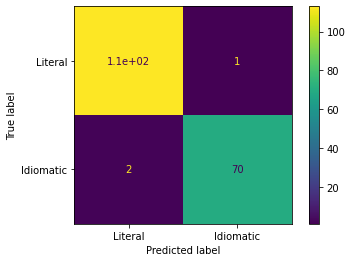

In [ ]:
matrix = confusion_matrix(np.argmax(labels_vnc_test_not_present, axis=1), np.argmax(preds, axis=1))
print(matrix)
disp = ConfusionMatrixDisplay(matrix, display_labels=['Literal', 'Idiomatic'])
disp.plot()

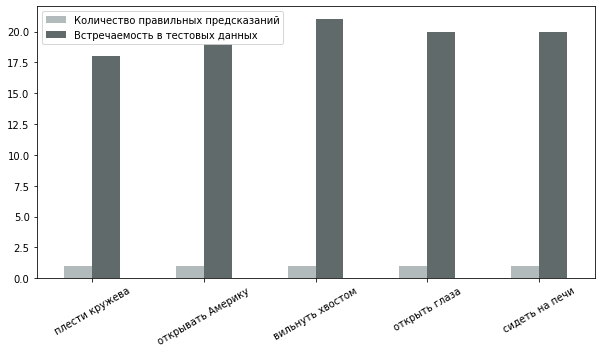

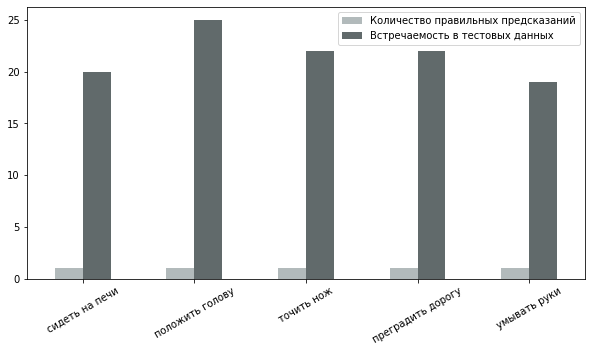

In [ ]:
idioms_test_not_present = data_vnc_test['Idiom Normal']
define_best_and_worst_ratios_not_in_train(preds, labels_vnc_test_not_present, idioms_test_not_present, k=5)

In [ ]:
model_vnc_4 = build_model()
model_vnc_4.fit(embedded_contexts_vnc_train[:200], labels_vnc_train_not_present[:200], batch_size=8, epochs=10)

compiled model
Epoch 1/10
25/25 [==============================] - 8s 109ms/step - loss: 0.7002 - accuracy: 0.5550
Epoch 2/10
25/25 [==============================] - 3s 106ms/step - loss: 0.5594 - accuracy: 0.7550
Epoch 3/10
25/25 [==============================] - 3s 109ms/step - loss: 0.4748 - accuracy: 0.8100
Epoch 4/10
25/25 [==============================] - 3s 107ms/step - loss: 0.4038 - accuracy: 0.8450
Epoch 5/10
25/25 [==============================] - 3s 109ms/step - loss: 0.3220 - accuracy: 0.9050
Epoch 6/10
25/25 [==============================] - 3s 105ms/step - loss: 0.2671 - accuracy: 0.9300
Epoch 7/10
25/25 [==============================] - 3s 105ms/step - loss: 0.2319 - accuracy: 0.9350
Epoch 8/10
25/25 [==============================] - 3s 105ms/step - loss: 0.1617 - accuracy: 0.9750
Epoch 9/10
25/25 [==============================] - 3s 104ms/step - loss: 0.1490 - accuracy: 0.9550
Epoch 10/10
25/25 [==============================] - 3s 106ms/step - loss: 0.1020 - a

In [ ]:
model_vnc_4.evaluate(np.asarray(embedded_contexts_vnc_test), labels_vnc_test_not_present)

6/6 [==============================] - 3s 78ms/step - loss: 0.4353 - accuracy: 0.8387


[0.435305118560791, 0.8387096524238586]

# Dataset size experiments

## 70%

In [ ]:
train_size = 0.7 * 0.7 * len(embedded_contexts)
print(train_size)
test_size = 0.3 * len(embedded_contexts)
test_size

832.5099999999999


509.7

In [ ]:
X_sample_train = random.Random(42).sample(embedded_contexts, 833)
X_sample_train = tf.convert_to_tensor(X_sample_train)
labels_train_sample = random.Random(42).sample(list(data.Label), 833)
labels_train_sample = to_categorical(labels_train_sample)

X_sample_test = random.Random(2).sample(embedded_contexts, 510)
X_sample_test= tf.convert_to_tensor(X_sample_test)
labels_test_sample = random.Random(2).sample(list(data.Label), 510)
labels_test_sample = to_categorical(labels_test_sample)

In [ ]:
model_all_4 = build_model()
model_all_4.fit(X_sample_train, labels_train_sample, batch_size=8, epochs=10)

compiled model
Epoch 1/10
105/105 [==============================] - 20s 137ms/step - loss: 0.7284 - accuracy: 0.5006
Epoch 2/10
105/105 [==============================] - 14s 138ms/step - loss: 0.6889 - accuracy: 0.5534
Epoch 3/10
105/105 [==============================] - 14s 137ms/step - loss: 0.6678 - accuracy: 0.6062
Epoch 4/10
105/105 [==============================] - 14s 136ms/step - loss: 0.6350 - accuracy: 0.6639
Epoch 5/10
105/105 [==============================] - 14s 137ms/step - loss: 0.5987 - accuracy: 0.6975
Epoch 6/10
105/105 [==============================] - 14s 135ms/step - loss: 0.5650 - accuracy: 0.7323
Epoch 7/10
105/105 [==============================] - 14s 138ms/step - loss: 0.5087 - accuracy: 0.7791
Epoch 8/10
105/105 [==============================] - 14s 135ms/step - loss: 0.4761 - accuracy: 0.7911
Epoch 9/10
105/105 [==============================] - 14s 136ms/step - loss: 0.4658 - accuracy: 0.7875
Epoch 10/10
105/105 [==============================] - 14s

In [ ]:
model_all_4.evaluate(np.asarray(X_sample_test), labels_test_sample)
                     
acc = model_all_4.evaluate(X_sample_test, labels_test_sample)[1]
preds = model_all_4.predict(np.array(X_sample_test))
f_score = f1_score(np.argmax(preds, axis=1), np.argmax(labels_test_sample, axis=1))
roc_auc = roc_auc_score(labels_test_sample, preds)

print('Accuracy: {}\nF-score: {}\nROC AUC: {}'.format(acc, f_score, roc_auc))
roc_auc_score(labels_test_sample,preds)

16/16 [==============================] - 1s 57ms/step - loss: 0.5681 - accuracy: 0.7275
Accuracy: 0.727450966835022
F-score: 0.729044834307992
ROC AUC: 0.7945428817521841


0.7945428817521841

In [ ]:
X_sample_train = random.Random(2).sample(embedded_contexts, 833)
X_sample_train = tf.convert_to_tensor(X_sample_train)
labels_train_sample = random.Random(2).sample(list(data.Label), 833)
labels_train_sample = to_categorical(labels_train_sample)

X_sample_test = random.Random(22).sample(embedded_contexts, 510)
X_sample_test= tf.convert_to_tensor(X_sample_test)
labels_test_sample = random.Random(22).sample(list(data.Label), 510)
labels_test_sample = to_categorical(labels_test_sample)

In [ ]:
model_all_4 = build_model()
model_all_4.fit(X_sample_train, labels_train_sample, batch_size=8, epochs=10)

model_all_4.evaluate(np.asarray(X_sample_test), labels_test_sample)
                     
acc = model_all_4.evaluate(X_sample_test, labels_test_sample)[1]
preds = model_all_4.predict(np.array(X_sample_test))
f_score = f1_score(np.argmax(preds, axis=1), np.argmax(labels_test_sample, axis=1))
roc_auc = roc_auc_score(labels_test_sample, preds)

print('Accuracy: {}\nF-score: {}\nROC AUC: {}'.format(acc, f_score, roc_auc))
roc_auc_score(labels_test_sample,preds)

compiled model
Epoch 1/10
105/105 [==============================] - 20s 138ms/step - loss: 0.7172 - accuracy: 0.5138
Epoch 2/10
105/105 [==============================] - 15s 139ms/step - loss: 0.6821 - accuracy: 0.5870
Epoch 3/10
105/105 [==============================] - 15s 138ms/step - loss: 0.6668 - accuracy: 0.6110
Epoch 4/10
105/105 [==============================] - 14s 137ms/step - loss: 0.6378 - accuracy: 0.6699
Epoch 5/10
105/105 [==============================] - 15s 139ms/step - loss: 0.6013 - accuracy: 0.7059
Epoch 6/10
105/105 [==============================] - 14s 137ms/step - loss: 0.5706 - accuracy: 0.7299
Epoch 7/10
105/105 [==============================] - 14s 138ms/step - loss: 0.5144 - accuracy: 0.7755
Epoch 8/10
105/105 [==============================] - 14s 137ms/step - loss: 0.4859 - accuracy: 0.7863
Epoch 9/10
105/105 [==============================] - 15s 138ms/step - loss: 0.4512 - accuracy: 0.7887
Epoch 10/10
16/16 [==============================] - 1s 58

0.7645964070382676

In [ ]:
X_sample_train = random.Random(10).sample(embedded_contexts, 833)
X_sample_train = tf.convert_to_tensor(X_sample_train)
labels_train_sample = random.Random(10).sample(list(data.Label), 833)
labels_train_sample = to_categorical(labels_train_sample)

X_sample_test = random.Random(100).sample(embedded_contexts, 510)
X_sample_test= tf.convert_to_tensor(X_sample_test)
labels_test_sample = random.Random(100).sample(list(data.Label), 510)
labels_test_sample = to_categorical(labels_test_sample)

In [ ]:
model_all_4 = build_model()
model_all_4.fit(X_sample_train, labels_train_sample, batch_size=8, epochs=10)

model_all_4.evaluate(np.asarray(X_sample_test), labels_test_sample)
                     
acc = model_all_4.evaluate(X_sample_test, labels_test_sample)[1]
preds = model_all_4.predict(np.array(X_sample_test))
f_score = f1_score(np.argmax(preds, axis=1), np.argmax(labels_test_sample, axis=1))
roc_auc = roc_auc_score(labels_test_sample, preds)

print('Accuracy: {}\nF-score: {}\nROC AUC: {}'.format(acc, f_score, roc_auc))
roc_auc_score(labels_test_sample,preds)

compiled model
Epoch 1/10
105/105 [==============================] - 24s 139ms/step - loss: 0.7299 - accuracy: 0.5150
Epoch 2/10
105/105 [==============================] - 15s 138ms/step - loss: 0.6880 - accuracy: 0.5498
Epoch 3/10
105/105 [==============================] - 14s 138ms/step - loss: 0.6619 - accuracy: 0.5930
Epoch 4/10
105/105 [==============================] - 14s 137ms/step - loss: 0.6166 - accuracy: 0.6627
Epoch 5/10
105/105 [==============================] - 14s 138ms/step - loss: 0.5872 - accuracy: 0.6891
Epoch 6/10
105/105 [==============================] - 15s 138ms/step - loss: 0.5499 - accuracy: 0.7419
Epoch 7/10
105/105 [==============================] - 14s 138ms/step - loss: 0.5092 - accuracy: 0.7575
Epoch 8/10
105/105 [==============================] - 14s 136ms/step - loss: 0.4709 - accuracy: 0.7983
Epoch 9/10
105/105 [==============================] - 14s 137ms/step - loss: 0.4550 - accuracy: 0.8031
Epoch 10/10
16/16 [==============================] - 1s 56

0.8067091177556294

## 50%

In [ ]:
train_size = 0.7 * 0.5 * len(embedded_contexts)
print(train_size)
test_size = 0.3 * len(embedded_contexts)
test_size

594.65


509.7

In [ ]:
X_sample_train = random.Random(15).sample(embedded_contexts, 595)
X_sample_train = tf.convert_to_tensor(X_sample_train)
labels_train_sample = random.Random(15).sample(list(data.Label), 595)
labels_train_sample = to_categorical(labels_train_sample)

X_sample_test = random.Random(26).sample(embedded_contexts, 510)
X_sample_test= tf.convert_to_tensor(X_sample_test)
labels_test_sample = random.Random(26).sample(list(data.Label), 510)
labels_test_sample = to_categorical(labels_test_sample)

In [ ]:
model_all_4 = build_model()
model_all_4.fit(X_sample_train, labels_train_sample, batch_size=8, epochs=10)

model_all_4.evaluate(np.asarray(X_sample_test), labels_test_sample)
                     
acc = model_all_4.evaluate(X_sample_test, labels_test_sample)[1]
preds = model_all_4.predict(np.array(X_sample_test))
f_score = f1_score(np.argmax(preds, axis=1), np.argmax(labels_test_sample, axis=1))
roc_auc = roc_auc_score(labels_test_sample, preds)

print('Accuracy: {}\nF-score: {}\nROC AUC: {}'.format(acc, f_score, roc_auc))
roc_auc_score(labels_test_sample,preds)

compiled model
Epoch 1/10
75/75 [==============================] - 16s 136ms/step - loss: 0.7218 - accuracy: 0.5008
Epoch 2/10
75/75 [==============================] - 10s 137ms/step - loss: 0.6916 - accuracy: 0.5563
Epoch 3/10
75/75 [==============================] - 10s 135ms/step - loss: 0.6623 - accuracy: 0.5933
Epoch 4/10
75/75 [==============================] - 10s 136ms/step - loss: 0.6292 - accuracy: 0.6689
Epoch 5/10
75/75 [==============================] - 10s 136ms/step - loss: 0.5786 - accuracy: 0.7361
Epoch 6/10
75/75 [==============================] - 10s 136ms/step - loss: 0.5496 - accuracy: 0.7479
Epoch 7/10
75/75 [==============================] - 10s 135ms/step - loss: 0.5137 - accuracy: 0.7580
Epoch 8/10
75/75 [==============================] - 10s 136ms/step - loss: 0.4766 - accuracy: 0.8000
Epoch 9/10
75/75 [==============================] - 10s 135ms/step - loss: 0.4321 - accuracy: 0.8387
Epoch 10/10
16/16 [==============================] - 1s 55ms/step - loss: 0.

0.7198305737389297

In [ ]:
model_all_4 = build_model()
X_sample_train = random.Random(25).sample(embedded_contexts, 595)
X_sample_train = tf.convert_to_tensor(X_sample_train)
labels_train_sample = random.Random(25).sample(list(data.Label), 595)
labels_train_sample = to_categorical(labels_train_sample)

X_sample_test = random.Random(55).sample(embedded_contexts, 510)
X_sample_test= tf.convert_to_tensor(X_sample_test)
labels_test_sample = random.Random(55).sample(list(data.Label), 510)
labels_test_sample = to_categorical(labels_test_sample)

compiled model


In [ ]:
model_all_4.fit(X_sample_train, labels_train_sample, batch_size=8, epochs=10)

model_all_4.evaluate(np.asarray(X_sample_test), labels_test_sample)
                     
acc = model_all_4.evaluate(X_sample_test, labels_test_sample)[1]
preds = model_all_4.predict(np.array(X_sample_test))
f_score = f1_score(np.argmax(preds, axis=1), np.argmax(labels_test_sample, axis=1))
roc_auc = roc_auc_score(labels_test_sample, preds)

print('Accuracy: {}\nF-score: {}\nROC AUC: {}'.format(acc, f_score, roc_auc))
roc_auc_score(labels_test_sample,preds)

Epoch 1/10
75/75 [==============================] - 18s 139ms/step - loss: 0.7393 - accuracy: 0.4672
Epoch 2/10
75/75 [==============================] - 10s 139ms/step - loss: 0.6970 - accuracy: 0.5496
Epoch 3/10
75/75 [==============================] - 11s 141ms/step - loss: 0.6713 - accuracy: 0.5966
Epoch 4/10
75/75 [==============================] - 10s 139ms/step - loss: 0.6446 - accuracy: 0.6387
Epoch 5/10
75/75 [==============================] - 10s 140ms/step - loss: 0.5923 - accuracy: 0.7328
Epoch 6/10
75/75 [==============================] - 11s 141ms/step - loss: 0.5411 - accuracy: 0.7714
Epoch 7/10
75/75 [==============================] - 10s 139ms/step - loss: 0.5167 - accuracy: 0.7731
Epoch 8/10
75/75 [==============================] - 10s 140ms/step - loss: 0.4606 - accuracy: 0.8017
Epoch 9/10
75/75 [==============================] - 10s 140ms/step - loss: 0.4364 - accuracy: 0.8252
Epoch 10/10
16/16 [==============================] - 1s 57ms/step - loss: 0.7228 - accuracy

0.6906490343860299

In [ ]:
X_sample_train = random.Random(32).sample(embedded_contexts, 595)
X_sample_train = tf.convert_to_tensor(X_sample_train)
labels_train_sample = random.Random(32).sample(list(data.Label), 595)
labels_train_sample = to_categorical(labels_train_sample)

X_sample_test = random.Random(67).sample(embedded_contexts, 510)
X_sample_test= tf.convert_to_tensor(X_sample_test)
labels_test_sample = random.Random(67).sample(list(data.Label), 510)
labels_test_sample = to_categorical(labels_test_sample)

In [ ]:
model_all_4 = build_model()
model_all_4.fit(X_sample_train, labels_train_sample, batch_size=8, epochs=10)

model_all_4.evaluate(np.asarray(X_sample_test), labels_test_sample)
                     
acc = model_all_4.evaluate(X_sample_test, labels_test_sample)[1]
preds = model_all_4.predict(np.array(X_sample_test))
f_score = f1_score(np.argmax(preds, axis=1), np.argmax(labels_test_sample, axis=1))
roc_auc = roc_auc_score(labels_test_sample, preds)

print('Accuracy: {}\nF-score: {}\nROC AUC: {}'.format(acc, f_score, roc_auc))
roc_auc_score(labels_test_sample,preds)

compiled model
Epoch 1/10
75/75 [==============================] - 16s 138ms/step - loss: 0.7143 - accuracy: 0.5092
Epoch 2/10
75/75 [==============================] - 10s 138ms/step - loss: 0.6873 - accuracy: 0.5395
Epoch 3/10
75/75 [==============================] - 10s 138ms/step - loss: 0.6556 - accuracy: 0.6319
Epoch 4/10
75/75 [==============================] - 10s 140ms/step - loss: 0.6409 - accuracy: 0.6437
Epoch 5/10
75/75 [==============================] - 10s 139ms/step - loss: 0.5921 - accuracy: 0.7193
Epoch 6/10
75/75 [==============================] - 10s 138ms/step - loss: 0.5612 - accuracy: 0.7412
Epoch 7/10
75/75 [==============================] - 10s 138ms/step - loss: 0.5142 - accuracy: 0.7933
Epoch 8/10
75/75 [==============================] - 10s 137ms/step - loss: 0.4691 - accuracy: 0.8084
Epoch 9/10
75/75 [==============================] - 10s 137ms/step - loss: 0.4523 - accuracy: 0.8084
Epoch 10/10
16/16 [==============================] - 1s 57ms/step - loss: 0.

0.6873044496848076

## 30 %

In [ ]:
train_size = 0.7 * 0.3 * len(embedded_contexts)
print(train_size)
test_size = 0.3 * len(embedded_contexts)
test_size

356.78999999999996


509.7

In [ ]:
X_sample_train = random.Random(4).sample(embedded_contexts, 358)
X_sample_train = tf.convert_to_tensor(X_sample_train)
labels_train_sample = random.Random(4).sample(list(data.Label), 358)
labels_train_sample = to_categorical(labels_train_sample)

X_sample_test = random.Random(40).sample(embedded_contexts, 510)
X_sample_test= tf.convert_to_tensor(X_sample_test)
labels_test_sample = random.Random(40).sample(list(data.Label), 510)
labels_test_sample = to_categorical(labels_test_sample)

model_all_4.fit(X_sample_train, labels_train_sample, batch_size=8, epochs=10)

model_all_4.evaluate(np.asarray(X_sample_test), labels_test_sample)
                     
acc = model_all_4.evaluate(X_sample_test, labels_test_sample)[1]
preds = model_all_4.predict(np.array(X_sample_test))
f_score = f1_score(np.argmax(preds, axis=1), np.argmax(labels_test_sample, axis=1))
roc_auc = roc_auc_score(labels_test_sample, preds)

print('Accuracy: {}\nF-score: {}\nROC AUC: {}'.format(acc, f_score, roc_auc))
roc_auc_score(labels_test_sample,preds)

Epoch 1/10
45/45 [==============================] - 6s 138ms/step - loss: 0.7314 - accuracy: 0.5950
Epoch 2/10
45/45 [==============================] - 6s 137ms/step - loss: 0.5898 - accuracy: 0.6816
Epoch 3/10
45/45 [==============================] - 6s 138ms/step - loss: 0.5760 - accuracy: 0.7291
Epoch 4/10
45/45 [==============================] - 6s 136ms/step - loss: 0.4898 - accuracy: 0.7765
Epoch 5/10
45/45 [==============================] - 6s 137ms/step - loss: 0.4255 - accuracy: 0.8184
Epoch 6/10
45/45 [==============================] - 6s 138ms/step - loss: 0.4060 - accuracy: 0.8212
Epoch 7/10
45/45 [==============================] - 6s 135ms/step - loss: 0.3519 - accuracy: 0.8715
Epoch 8/10
45/45 [==============================] - 6s 135ms/step - loss: 0.3059 - accuracy: 0.8966
Epoch 9/10
45/45 [==============================] - 6s 136ms/step - loss: 0.2419 - accuracy: 0.9246
Epoch 10/10
16/16 [==============================] - 1s 58ms/step - loss: 0.7750 - accuracy: 0.6804


0.7260030864197531

In [ ]:
X_sample_train = random.Random(14).sample(embedded_contexts, 358)
X_sample_train = tf.convert_to_tensor(X_sample_train)
labels_train_sample = random.Random(14).sample(list(data.Label), 358)
labels_train_sample = to_categorical(labels_train_sample)

X_sample_test = random.Random(9).sample(embedded_contexts, 510)
X_sample_test= tf.convert_to_tensor(X_sample_test)
labels_test_sample = random.Random(9).sample(list(data.Label), 510)
labels_test_sample = to_categorical(labels_test_sample)

model_all_4 = build_model()
model_all_4.fit(X_sample_train, labels_train_sample, batch_size=8, epochs=10)

model_all_4.evaluate(np.asarray(X_sample_test), labels_test_sample)
                     
acc = model_all_4.evaluate(X_sample_test, labels_test_sample)[1]
preds = model_all_4.predict(np.array(X_sample_test))
f_score = f1_score(np.argmax(preds, axis=1), np.argmax(labels_test_sample, axis=1))
roc_auc = roc_auc_score(labels_test_sample, preds)

print('Accuracy: {}\nF-score: {}\nROC AUC: {}'.format(acc, f_score, roc_auc))
roc_auc_score(labels_test_sample,preds)

compiled model
Epoch 1/10
45/45 [==============================] - 12s 136ms/step - loss: 0.7182 - accuracy: 0.5335
Epoch 2/10
45/45 [==============================] - 6s 136ms/step - loss: 0.6906 - accuracy: 0.5726
Epoch 3/10
45/45 [==============================] - 6s 135ms/step - loss: 0.6638 - accuracy: 0.5950
Epoch 4/10
45/45 [==============================] - 6s 136ms/step - loss: 0.6248 - accuracy: 0.7179
Epoch 5/10
45/45 [==============================] - 6s 135ms/step - loss: 0.6121 - accuracy: 0.7067
Epoch 6/10
45/45 [==============================] - 6s 135ms/step - loss: 0.5779 - accuracy: 0.7318
Epoch 7/10
45/45 [==============================] - 6s 136ms/step - loss: 0.5504 - accuracy: 0.7570
Epoch 8/10
45/45 [==============================] - 6s 134ms/step - loss: 0.4745 - accuracy: 0.8324
Epoch 9/10
45/45 [==============================] - 6s 134ms/step - loss: 0.4399 - accuracy: 0.8408
Epoch 10/10
16/16 [==============================] - 1s 58ms/step - loss: 0.7462 - a

0.6320454230715967

In [ ]:
X_sample_train = random.Random(11).sample(embedded_contexts, 358)
X_sample_train = tf.convert_to_tensor(X_sample_train)
labels_train_sample = random.Random(11).sample(list(data.Label), 358)
labels_train_sample = to_categorical(labels_train_sample)

X_sample_test = random.Random(17).sample(embedded_contexts, 510)
X_sample_test= tf.convert_to_tensor(X_sample_test)
labels_test_sample = random.Random(17).sample(list(data.Label), 510)
labels_test_sample = to_categorical(labels_test_sample)

model_all_4 = build_model()
model_all_4.fit(X_sample_train, labels_train_sample, batch_size=8, epochs=10)

model_all_4.evaluate(np.asarray(X_sample_test), labels_test_sample)
                     
acc = model_all_4.evaluate(X_sample_test, labels_test_sample)[1]
preds = model_all_4.predict(np.array(X_sample_test))
f_score = f1_score(np.argmax(preds, axis=1), np.argmax(labels_test_sample, axis=1))
roc_auc = roc_auc_score(labels_test_sample, preds)

print('Accuracy: {}\nF-score: {}\nROC AUC: {}'.format(acc, f_score, roc_auc))
roc_auc_score(labels_test_sample,preds)

compiled model
Epoch 1/10
45/45 [==============================] - 12s 141ms/step - loss: 0.7224 - accuracy: 0.4944
Epoch 2/10
45/45 [==============================] - 6s 140ms/step - loss: 0.6731 - accuracy: 0.5810
Epoch 3/10
45/45 [==============================] - 6s 140ms/step - loss: 0.6568 - accuracy: 0.6257
Epoch 4/10
45/45 [==============================] - 6s 142ms/step - loss: 0.6213 - accuracy: 0.6927
Epoch 5/10
45/45 [==============================] - 6s 139ms/step - loss: 0.5727 - accuracy: 0.7514
Epoch 6/10
45/45 [==============================] - 6s 140ms/step - loss: 0.5403 - accuracy: 0.7626
Epoch 7/10
45/45 [==============================] - 6s 138ms/step - loss: 0.4689 - accuracy: 0.8240
Epoch 8/10
45/45 [==============================] - 6s 139ms/step - loss: 0.4300 - accuracy: 0.8324
Epoch 9/10
45/45 [==============================] - 6s 139ms/step - loss: 0.4049 - accuracy: 0.8520
Epoch 10/10
16/16 [==============================] - 1s 58ms/step - loss: 0.8271 - a

0.6522564807238032

## 10%

In [ ]:
train_size = 0.7 * 0.1 * len(embedded_contexts)
print(train_size)
test_size = 0.3 * len(embedded_contexts)
test_size

118.92999999999999


509.7

In [ ]:
X_sample_train = random.Random(101).sample(embedded_contexts, 119)
X_sample_train = tf.convert_to_tensor(X_sample_train)
labels_train_sample = random.Random(101).sample(list(data.Label), 119)
labels_train_sample = to_categorical(labels_train_sample)

X_sample_test = random.Random(7).sample(embedded_contexts, 510)
X_sample_test= tf.convert_to_tensor(X_sample_test)
labels_test_sample = random.Random(7).sample(list(data.Label), 510)
labels_test_sample = to_categorical(labels_test_sample)

model_all_4 = build_model()
model_all_4.fit(X_sample_train, labels_train_sample, batch_size=8, epochs=10)

model_all_4.evaluate(np.asarray(X_sample_test), labels_test_sample)
                     
acc = model_all_4.evaluate(X_sample_test, labels_test_sample)[1]
preds = model_all_4.predict(np.array(X_sample_test))
f_score = f1_score(np.argmax(preds, axis=1), np.argmax(labels_test_sample, axis=1))
roc_auc = roc_auc_score(labels_test_sample, preds)

print('Accuracy: {}\nF-score: {}\nROC AUC: {}'.format(acc, f_score, roc_auc))
roc_auc_score(labels_test_sample,preds)

compiled model
Epoch 1/10
15/15 [==============================] - 8s 137ms/step - loss: 0.7010 - accuracy: 0.5882
Epoch 2/10
15/15 [==============================] - 2s 139ms/step - loss: 0.6384 - accuracy: 0.6471
Epoch 3/10
15/15 [==============================] - 2s 143ms/step - loss: 0.6017 - accuracy: 0.6975
Epoch 4/10
15/15 [==============================] - 2s 142ms/step - loss: 0.5418 - accuracy: 0.7479
Epoch 5/10
15/15 [==============================] - 2s 141ms/step - loss: 0.4926 - accuracy: 0.8151
Epoch 6/10
15/15 [==============================] - 2s 140ms/step - loss: 0.4573 - accuracy: 0.8319
Epoch 7/10
15/15 [==============================] - 2s 139ms/step - loss: 0.4105 - accuracy: 0.8824
Epoch 8/10
15/15 [==============================] - 2s 139ms/step - loss: 0.3604 - accuracy: 0.9076
Epoch 9/10
15/15 [==============================] - 2s 139ms/step - loss: 0.3409 - accuracy: 0.9076
Epoch 10/10
16/16 [==============================] - 1s 58ms/step - loss: 0.8631 - ac

0.5165277777777778

In [ ]:
X_sample_train = random.Random(18).sample(embedded_contexts, 119)
X_sample_train = tf.convert_to_tensor(X_sample_train)
labels_train_sample = random.Random(18).sample(list(data.Label), 119)
labels_train_sample = to_categorical(labels_train_sample)

X_sample_test = random.Random(47).sample(embedded_contexts, 510)
X_sample_test= tf.convert_to_tensor(X_sample_test)
labels_test_sample = random.Random(47).sample(list(data.Label), 510)
labels_test_sample = to_categorical(labels_test_sample)

model_all_4 = build_model()
model_all_4.fit(X_sample_train, labels_train_sample, batch_size=8, epochs=10)

model_all_4.evaluate(np.asarray(X_sample_test), labels_test_sample)
                     
acc = model_all_4.evaluate(X_sample_test, labels_test_sample)[1]
preds = model_all_4.predict(np.array(X_sample_test))
f_score = f1_score(np.argmax(preds, axis=1), np.argmax(labels_test_sample, axis=1))
roc_auc = roc_auc_score(labels_test_sample, preds)

print('Accuracy: {}\nF-score: {}\nROC AUC: {}'.format(acc, f_score, roc_auc))
roc_auc_score(labels_test_sample,preds)

compiled model
Epoch 1/10
15/15 [==============================] - 8s 141ms/step - loss: 0.7388 - accuracy: 0.5462
Epoch 2/10
15/15 [==============================] - 2s 138ms/step - loss: 0.6484 - accuracy: 0.6050
Epoch 3/10
15/15 [==============================] - 2s 139ms/step - loss: 0.6241 - accuracy: 0.6723
Epoch 4/10
15/15 [==============================] - 2s 140ms/step - loss: 0.5706 - accuracy: 0.7731
Epoch 5/10
15/15 [==============================] - 2s 139ms/step - loss: 0.5234 - accuracy: 0.7563
Epoch 6/10
15/15 [==============================] - 2s 138ms/step - loss: 0.4618 - accuracy: 0.8739
Epoch 7/10
15/15 [==============================] - 2s 138ms/step - loss: 0.4074 - accuracy: 0.8571
Epoch 8/10
15/15 [==============================] - 2s 140ms/step - loss: 0.3739 - accuracy: 0.8824
Epoch 9/10
15/15 [==============================] - 2s 141ms/step - loss: 0.3129 - accuracy: 0.9160
Epoch 10/10
16/16 [==============================] - 1s 57ms/step - loss: 0.9480 - ac

0.540429918909354

In [ ]:
X_sample_train = random.Random(67).sample(embedded_contexts, 119)
X_sample_train = tf.convert_to_tensor(X_sample_train)
labels_train_sample = random.Random(67).sample(list(data.Label), 119)
labels_train_sample = to_categorical(labels_train_sample)

X_sample_test = random.Random(99).sample(embedded_contexts, 510)
X_sample_test= tf.convert_to_tensor(X_sample_test)
labels_test_sample = random.Random(99).sample(list(data.Label), 510)
labels_test_sample = to_categorical(labels_test_sample)

model_all_4 = build_model()
model_all_4.fit(X_sample_train, labels_train_sample, batch_size=8, epochs=10)

model_all_4.evaluate(np.asarray(X_sample_test), labels_test_sample)
                     
acc = model_all_4.evaluate(X_sample_test, labels_test_sample)[1]
preds = model_all_4.predict(np.array(X_sample_test))
f_score = f1_score(np.argmax(preds, axis=1), np.argmax(labels_test_sample, axis=1))
roc_auc = roc_auc_score(labels_test_sample, preds)

print('Accuracy: {}\nF-score: {}\nROC AUC: {}'.format(acc, f_score, roc_auc))
roc_auc_score(labels_test_sample,preds)

compiled model
Epoch 1/10
15/15 [==============================] - 8s 136ms/step - loss: 0.7283 - accuracy: 0.5042
Epoch 2/10
15/15 [==============================] - 2s 139ms/step - loss: 0.6902 - accuracy: 0.5714
Epoch 3/10
15/15 [==============================] - 2s 139ms/step - loss: 0.6436 - accuracy: 0.6723
Epoch 4/10
15/15 [==============================] - 2s 136ms/step - loss: 0.5994 - accuracy: 0.7395
Epoch 5/10
15/15 [==============================] - 2s 136ms/step - loss: 0.5247 - accuracy: 0.8067
Epoch 6/10
15/15 [==============================] - 2s 135ms/step - loss: 0.4919 - accuracy: 0.8151
Epoch 7/10
15/15 [==============================] - 2s 139ms/step - loss: 0.3915 - accuracy: 0.9244
Epoch 8/10
15/15 [==============================] - 2s 134ms/step - loss: 0.3542 - accuracy: 0.9412
Epoch 9/10
15/15 [==============================] - 2s 136ms/step - loss: 0.3078 - accuracy: 0.9412
Epoch 10/10
16/16 [==============================] - 1s 57ms/step - loss: 0.8817 - ac

0.5485957132298596